# Analysis Raupennest ICF Data Part 1
This Notebook covers the first Raupennest Experiment to compare Participation disorder Evaluation data by medical professionalists and patients themselves.

In [25]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt
import random
import itertools
from scipy.stats import kstest,ttest_ind,mannwhitneyu, chi2_contingency, fisher_exact
import scipy

behandlercols = ['caremanager', 'nurse', 'physician', 'physiotherapist', 'psychologist']
randcols = list(
    itertools.chain.from_iterable([['rand' + str(k) + '-' + c for c in behandlercols] for k in range(1, 7)]))

pd.options.mode.copy_on_write = True  # to prevent pandas error when changing view/copy dataframes

url_prefix = 'https://static.94.87.140.128.clients.your-server.de/icfxapi/'
url_icf = url_prefix + 'icfdata/'
url_users = url_prefix + 'users/'
url_def_prefix = 'http://icfx-ressources.renecol.org/'
url_whodas_def = 'whodas12_en.json'
url_sf36_categories_def = 'sf36_categories_en.json'
url_sf36_def = 'sf36_de.json'
url_coreset_def = 'coresets.json'
url_icf_def = 'icf_codes3.json'
token = 'ddmFTxYJUTg1pIOP9ssCu6LHqY6wsv'

# get labels from definition file
r3 = requests.get(url_def_prefix + url_whodas_def).json()
# Coreset-Definitionen holen

r4 = requests.get(url_def_prefix + url_coreset_def).json()
# ICF Definitionen holen
r5 = requests.get(url_def_prefix + url_icf_def).json()


r6 = requests.get(url_def_prefix+url_sf36_categories_def).json()
r7 = requests.get(url_def_prefix+url_sf36_def).json()

## Generate Data Table from API
Only necessary if you dont have the data file (see below).

In [ ]:

# Requests
r = requests.get(url_icf, headers={'Authorization': 'Bearer ' + token}).json()
r2 = requests.get(url_users, headers={'Authorization': 'Bearer ' + token}).json()

df = pd.DataFrame(r).drop(columns=['owner_institution'])

# User Table erzeugen
df_users = pd.DataFrame(r2).drop(columns=['is_staff', 'date_joined', 'last_login', 'diagnoses','add_info']).set_index('id')

# den DAtensätzen die Erzeugergruppe zuweisen
df['creator_group'] = df.apply(lambda x: df_users.loc[x['creator'], 'groups'][0], axis=1)

# now expand the data column
df = pd.concat([df, df['data'].apply(pd.Series)], axis=1)

# filtern nach Zeitabschnitt
start_date = '2025-03-01'
end_date = '2025-05-31'
start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)


# icf datapart
def flipNumber(n, center=4):
    if n<center:
        return center+(center-n)
    if n>center:
        return center-(n-center)
    return n

def explode_icf_column(d):
    t = {}
    for k, v in d.items():
        if v['selected'] == 1:
            va=v['value']
            # wenn es sich hier um Kapitel e handelt, müssen die Werte noch gespiegelt werden, damit sie in die gleiche Richtung zeigen. Hohe Werte = hohe Beeinträchtigung
            if k[0]=='e':
                if va!=4: # exclude default vals
                    t[k] = flipNumber(v['value']) # flip 
            else:
                if va>0: # exclude default vals
                    t[k] = va
    return t


df['created'] = pd.to_datetime(df['created'])
df['created'] = df['created'].dt.tz_localize(None)
# Filter anwenden (inklusive Start- und Enddatum)
df = df[(df['created'] >= start_date) & (df['created'] <= end_date)]
print('Anzahl Patienten im Zeitraum %s - %s: %i'%(start_date,end_date, df['owner'].nunique()))
df['icfvals'] = df['icf'].apply(explode_icf_column)


df_selected_patients = pd.read_excel('raupennest/raupennest_population_with_pseudonym.xlsx')
# filter df to include only owner == uuid in df_selected_patients['uuid']
df2 = df[df['owner'].isin(df_selected_patients['uuid'])]
print('Anzahl Patienten nach Filterung auf Raupennest Population: %i'%(df2['owner'].nunique()))
df2.to_pickle('raupennest/icf_data_raupennest_part1.pkl')
df2.to_excel('raupennest/icf_data_raupennest_part1.xlsx')

# Read Data from file

In [2]:
df2 = pd.read_pickle('raupennest/icf_data_raupennest_part1.pkl')

# Analysis WHODAS and SF36
This step is necessary to show validity of participation limitations to quality of life.

In [3]:
# Nur Patientendaten extrahieren
df=df2
df_patients=df[df['owner']==df['creator']]

df_sf36=df_patients['sf36'].apply(pd.Series).dropna()
def sf36_normalizer(s):
    key = s.name
    n_possibleAnswers = len(r7[key]['answers'])
    defaultAnswer = r7[key]['default']
    base100_factor = 100/n_possibleAnswers
    if defaultAnswer == n_possibleAnswers-1:
        # ascending scale -> best possible result is highest score
        return base100_factor*(s+1)
    else:
        # descending scale
        return base100_factor*(n_possibleAnswers-s)

    
df_sf36_n=df_sf36.apply(sf36_normalizer)
df_sf36_definitions = pd.DataFrame(r7)
df_sf36_grouped = pd.DataFrame(index=df_sf36.index)
for group in r6:
    print(group['keys'])
    df_sf36_grouped[group['abbr']]=df_sf36_n[group['keys']].mean(axis=1)
cat_descriptions = {item['abbr']:item['title']+'(SF36)' for item in r6}
df_sf36_grouped2 = df_sf36_grouped.rename(columns=cat_descriptions)

['Q3a', 'Q3b', 'Q3c', 'Q3d', 'Q3e', 'Q3f', 'Q3g', 'Q3h', 'Q3i', 'Q3j']
['Q4a', 'Q4b', 'Q4c', 'Q4d']
['Q7', 'Q8']
['Q1', 'Q11a', 'Q11b', 'Q11c', 'Q11d']
['Q9a', 'Q9e', 'Q9g', 'Q9i']
['Q6', 'Q10']
['Q5a', 'Q5b', 'Q5c']
['Q9b', 'Q9c', 'Q9d', 'Q9f', 'Q9h']
['Q2']
['Q1']


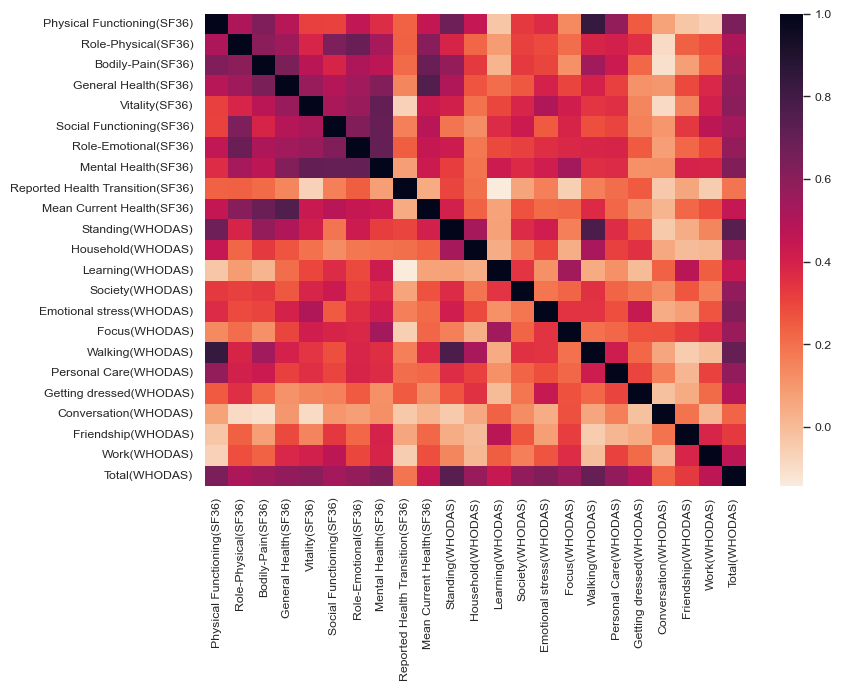

In [57]:
df_whodas=df_patients['whodas'].apply(pd.Series)

def renameColumn(c):
    return r3[c]['s']+'(WHODAS)'

df_whodas.rename(columns={c: renameColumn(c) for c in df_whodas.columns}, inplace=True)
df_whodas['Total(WHODAS)']=df_whodas.mean(axis=1)
df_whodas_n=(5-df_whodas)*20
df_combined=pd.concat([df_sf36_grouped2, df_whodas_n], axis=1)
corr=df_combined.corr()
plt.figure(figsize=[9,7])
p=sns.heatmap(corr,cmap='rocket_r')
SMALL_SIZE = 6
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.tight_layout()
p.figure.savefig('output/raupennest/sf36-whodas-correlation-heatmap.jpg',dpi=600)

In [5]:
# print correlations in descending order
corr_pairs = corr.iloc[:10,10:].unstack()

sorted_corr = corr_pairs.sort_values(ascending=False)
# remove self correlations
sorted_corr = sorted_corr[sorted_corr < 1.0]

print(sorted_corr)

Walking(WHODAS)       Physical Functioning(SF36)          0.836954
Standing(WHODAS)      Physical Functioning(SF36)          0.676474
Total(WHODAS)         Physical Functioning(SF36)          0.644460
                      Mental Health(SF36)                 0.629466
                      Vitality(SF36)                      0.597227
                                                            ...   
Work(WHODAS)          Physical Functioning(SF36)         -0.065193
Conversation(WHODAS)  Vitality(SF36)                     -0.089421
                      Role-Physical(SF36)                -0.089504
                      Bodily-Pain(SF36)                  -0.109749
Learning(WHODAS)      Reported Health Transition(SF36)   -0.142565
Length: 130, dtype: float64


In [6]:
sorted_corr.to_excel('output/raupennest/sf36-whodas-correlation-values.xlsx')

# Differences between Professional and Patient
## How many Assessments by which professional group

In [7]:
df['merged'] = df['merge'].apply(bool)
df_behandler = df[df['owner'] != df['creator']]
g1=df_behandler.groupby(['owner','merged'])['creator_group'].agg(['count'])
g2=df_behandler.groupby(['owner','merged'])['creator'].agg(['count'])

### by Professional group

In [8]:
# merged=True, d.h. 2nd look
g1.loc[(slice(None),True),:].agg(['mean','std'])

,count
mean,4.185185
std,1.542004


In [9]:
# merged=False, d.h. first look
g1.loc[(slice(None),False),:].agg(['mean','std'])

,count
mean,4.463415
std,0.932210


### by individual Professionals

In [10]:
# merged=True, d.h. 2nd look
g2.loc[(slice(None),True),:].agg(['mean','std'])

,count
mean,4.185185
std,1.542004


In [11]:
# merged=False, d.h. first look
g2.loc[(slice(None),False),:].agg(['mean','std'])

,count
mean,4.463415
std,0.932210


As the means of comparison by group and by individual are the same, it is proven that there was only one individual professional per group per patient assessment and the group value is not diluted by many individual observers.

## Differences Patient - Professional
### Massage Data into long format

In [12]:
# Aufbrechen der ICF Zelle in viele Spalten
df2_icf = df2['icfvals'].apply(pd.Series)
# nur die Spalten behalten, deren code mit d anfängt
df2_icf=df2_icf.filter(like='d', axis=1)
df2_icf = pd.concat([df2, df2_icf], axis=1)

df2_icf.drop(
    columns=['diagnoses', 'created', 'last_modified', 'data', 'merge', 'creator', 'env', 'icf', 'whodas', 'sf36',
             'coreset', 'lastActiveIcf', 'uxquestionnaire', 'icfvals'], inplace=True)
# long format erzeugen, um besser manipulieren zu können
df_icf_l = pd.melt(df2_icf, id_vars=['owner', 'id', 'creator_group', 'merged'], var_name='icf_code',
                   value_name='icf_value')

In [13]:
# create duplicate patient records, where merge = True
df_icf_l2 = df_icf_l.loc[df_icf_l['creator_group'] == 'patient']
df_icf_l2.loc[:, 'merged'] = True

df_icf_l.drop(columns=['id'],inplace=True)
df_icf_l2.drop(columns=['id'],inplace=True)
# combine
df_icf_l3 = pd.concat([df_icf_l, df_icf_l2], ignore_index=True)
df_icf_l3.dropna(inplace=True)
# switchen der Achsen: Columns werden die icf creator groups, die Zeilen werden als Multiindex abgebildet (owner/icf_code/merge-status)

df_icf_p_a = df_icf_l3.pivot_table(values='icf_value', index=['owner', 'icf_code', 'merged'], columns=['creator_group'])

## Calculate Convergency to ICF item from Patient and Professional side

In [14]:
# Gesamtanzahl der ICF Items pro Behandlergruppe und Merge-Status
df_icf_n=df_icf_p_a.loc[(slice(None), slice(None))].groupby(level=[1, 2]).count()
# Menge an Diff ICF Items (Zusammentreffende) und Gesamt-ICF Items in einer Tabelle
df_icf_p3 = df_icf_p_a.loc[(slice(None), slice(None))].groupby(level=[0, 2]).count()

def getRelIcfHit(x, g):
    if x[g] == 0:
        return None
    else:
        return x['diff_' + g] / (x[g])

# Subtrahieren der Patientenangabe
def normalize2Patient2(x, g):
    return x[g] - x['patient']


for c in df_icf_p_a.columns:
    df_icf_p_a['diff_' + c] = df_icf_p_a.apply(lambda x: normalize2Patient2(x, c), axis=1)
    
# Nur die Differenzen behalten
df_icf_p = df_icf_p_a.filter(like='diff_')
# Selektionieren aus dem Multiindex owner/icf_code/merge -> alle/alle/alle
# Zählen auf owner-Ebene (level =0) oder IcfCode Ebene (level=1) oder Merge (level=2)
df_icf_p_icfhits_absolut = df_icf_p.loc[(slice(None), slice(None))].groupby(level=[1,2]).count()

df_icf_p_icfhits_absolut.drop(columns=['diff_patient'], inplace=True)
df_icf_p_icfhits_absolut.rename(columns={c: c.split('_')[1] for c in df_icf_p_icfhits_absolut.columns}, inplace=True)
# konvergierte ICF Items durch Gesamtanzahl der ICF Items teilen, die Zeilen entfernen, die nur NaN Werte haben
df_icf_p_icfhits = (df_icf_p_icfhits_absolut / df_icf_n).dropna(how='all').drop(columns=['patient'])

In [20]:
# drop rows where valueas are either 0 or none for all columns
# 0 values are equal to no convergence
df_icf_p_icfhits = df_icf_p_icfhits[(df_icf_p_icfhits > 0).any(axis=1)]

### ICF Convergency between different Professional groups

In [21]:
# mean convergence rates by behandler group and merge status
df_icf_p_icfhits.groupby(level=1).agg(['mean'])

creator_group,caremanager,nurse,physician,physiotherapist,psychologist
,mean,mean,mean,mean,mean
merged,,,,,
False,0.45086,0.569327,0.415544,0.420807,0.565347
True,0.71718,0.688776,0.721969,0.734934,0.496079


In [22]:
# overall mean convergence rates by behandler group
df_icf_p_icfhits.groupby(level=1).agg(['mean']).T.mean()

merged
False    0.484377
True     0.671788
dtype: float64

In [23]:
# overall std convergence rates by behandler group
df_icf_p_icfhits.groupby(level=1).agg(['mean']).T.std()

merged
False    0.076934
True     0.099660
dtype: float64

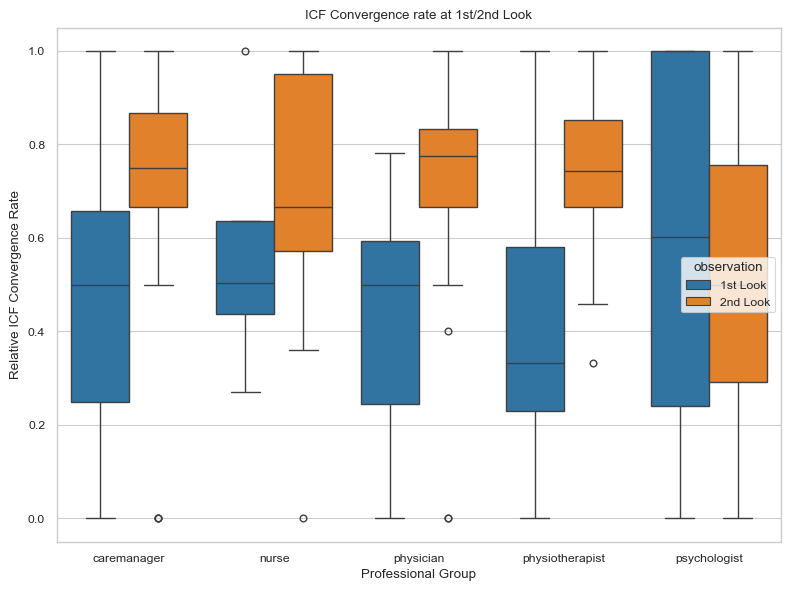

In [24]:
# boxplot of convergence rates by behandler group and merge status
df_icf_convergence=df_icf_p_icfhits.unstack().melt(value_name='rel_icf_convergence')
df_icf_convergence['observation']=df_icf_convergence['merged'].apply(lambda x: '2nd Look' if x else '1st Look')
df_icf_convergence.drop(columns=['merged'], inplace=True)
sns.set_context('paper')
plt.figure(figsize=(8,6))
sns.boxplot(data=df_icf_convergence, x='creator_group', y='rel_icf_convergence', hue='observation', hue_order=['1st Look','2nd Look'])
plt.title('ICF Convergence rate at 1st/2nd Look')
plt.ylabel('Relative ICF Convergence Rate')
plt.xlabel('Professional Group')
plt.tight_layout()
plt.savefig('output/raupennest/icf-convergence-boxplot-by-behandlergroup-and-1st-2nd-look.jpg', dpi=600)

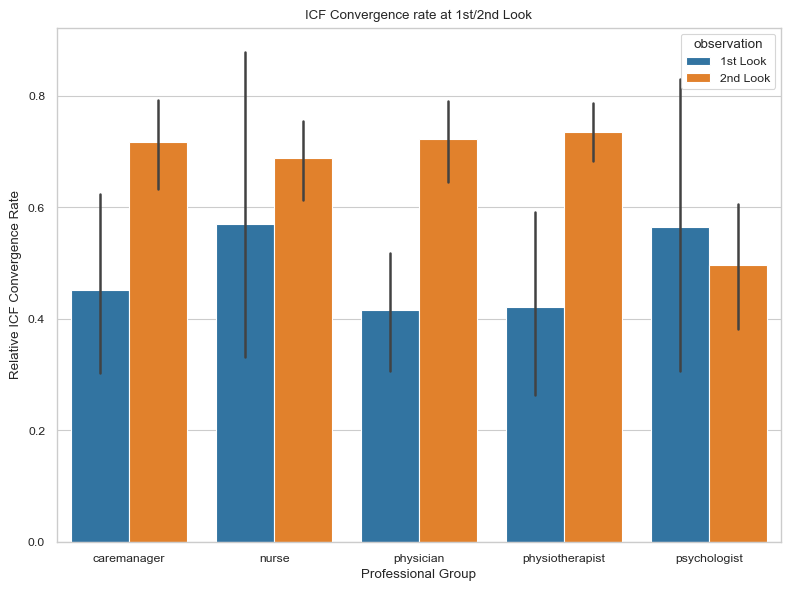

In [56]:
# do the same as barplot
plt.figure(figsize=(8,6))
sns.barplot(data=df_icf_convergence, x='creator_group', y='rel_icf_convergence', hue='observation', hue_order=['1st Look','2nd Look'])
plt.title('ICF Convergence rate at 1st/2nd Look')
plt.ylabel('Relative ICF Convergence Rate')
plt.xlabel('Professional Group')
plt.tight_layout()
plt.savefig('output/raupennest/icf-convergence-barplot-by-behandlergroup-and-1st-2nd-look.jpg', dpi=600)

### Statistical tests of convergency rates

In [29]:
# Perform Chi2 and Fisher Exact Test. Create contingency table from df_icf_p_hits_absolut and split index by merge status
results_chi2_fisher = []
for group in behandlercols:
    hits_1st = df_icf_p_icfhits_absolut.loc[(slice(None), False), group].sum()
    misses_1st = df_icf_n.loc[(slice(None), False), group].sum() - hits_1st
    hits_2nd = df_icf_p_icfhits_absolut.loc[(slice(None), True), group].sum()
    misses_2nd = df_icf_n.loc[(slice(None), True), group].sum() - hits_2nd
    contingency_table = [[hits_1st, misses_1st], [hits_2nd, misses_2nd]]
    chi2_stat, p_chi2, dof, ex = chi2_contingency(contingency_table)
    oddsratio, p_fisher = fisher_exact(contingency_table)
    results_chi2_fisher.append({'behandler_group': group, 
                    'chi2_statistic': chi2_stat, 'chi2_p_value': p_chi2,
                    'fisher_oddsratio': oddsratio, 'fisher_p_value': p_fisher}) 
df_chi2_fisher = pd.DataFrame(results_chi2_fisher)
df_chi2_fisher.to_excel('output/raupennest/icf-convergence-chi2-fisher-tests-1st-vs-2nd-look.xlsx')

In [32]:
# Perform Chi2 and Fisher Exact Test between behandler groups for 1st look and 2nd look separately, take contingency table from df_icf_p_hits_absolut and split index by merge status
results_chi2_fisher_groups = []
for look in [True, False]:
    for group1, group2 in itertools.combinations(behandlercols, 2):
        hits_1 = df_icf_p_icfhits_absolut.loc[(slice(None), look), group1].sum()
        misses_1 = df_icf_n.loc[(slice(None), look), group1].sum() - hits_1
        hits_2 = df_icf_p_icfhits_absolut.loc[(slice(None), look), group2].sum()
        misses_2 = df_icf_n.loc[(slice(None), look), group2].sum() - hits_2
        contingency_table = [[hits_1, misses_1], [hits_2, misses_2]]
        chi2_stat, p_chi2, dof, ex = chi2_contingency(contingency_table)
        oddsratio, p_fisher = fisher_exact(contingency_table)
        results_chi2_fisher_groups.append({'behandler_group_1': group1, 'behandler_group_2': group2, 'look': '2nd Look' if look else '1st Look', 
                        'chi2_statistic': chi2_stat, 'chi2_p_value': p_chi2,
                        'fisher_oddsratio': oddsratio, 'fisher_p_value': p_fisher})     
df_results_chi2_fisher_groups = pd.DataFrame(results_chi2_fisher_groups)
df_results_chi2_fisher_groups.to_excel('output/raupennest/icf-convergence-chi2-fisher-tests-between-behandler-groups-1st-vs-2nd-look.xlsx')

### Convergency rates by ICF Code

In [ ]:
df_icf_convergence_codes =df_icf_p_icfhits.loc[(slice(None),False),:].groupby(['icf_code']).agg(['mean']).T.mean().sort_values(ascending=False).rename('rel_icf_convergence')

In [ ]:
# pick description of icf code from r5 and combine with convergence rates
icf_descriptions = {key: item['t'] for key,item in r5.items()}
df_icf_convergence_codes2 = pd.DataFrame(df_icf_convergence_codes)
df_icf_convergence_codes2['description'] = df_icf_convergence_codes2.index.map(icf_descriptions)
df_icf_convergence_codes2 = df_icf_convergence_codes2[['description', 'rel_icf_convergence']]

In [ ]:
df_icf_convergence_codes2.to_excel('output/raupennest/icf-convergence-rates-by-icf-code-1st-look.xlsx')

## Quantitative Differences between Professional - Patient
### by professional group

In [50]:
df_icf_p_normalized = df_icf_p * 20 # scale to 0-100
# mean differences by behandler group and merge status
df_icf_diff=df_icf_p_normalized.groupby(level=[2]).agg(['mean','std']).drop(columns=['diff_patient'])
df_icf_diff.to_excel('output/raupennest/icf-differences-mean-std-by-behandler-group-and-1st-2nd-look.xlsx')

In [51]:
# rename the columns to only have the behandler group name
df_icf_diff2 = df_icf_p_normalized.rename(columns={c: c.split('_')[1] for c in df_icf_p_normalized.columns})
df_icf_diff2.drop(columns=['patient'], inplace=True)
# melt into long format
df_icf_diff_long = df_icf_diff2.reset_index().melt(id_vars=['owner', 'icf_code', 'merged'], var_name='creator_group', value_name='icf_diff').dropna()
df_icf_diff_long['observation']=df_icf_diff_long['merged'].apply(lambda x: '2nd Look' if x else '1st Look')
df_icf_diff_long.drop(columns=['merged'], inplace=True)

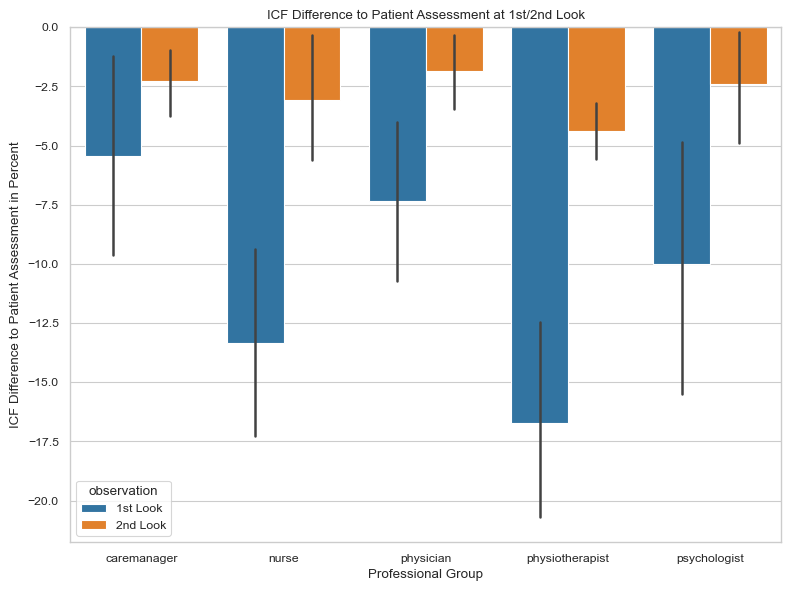

In [53]:
# create boxplot of icf_diff by creator_group and merged status

sns.set_context('paper')
plt.figure(figsize=(8,6))
sns.barplot(data=df_icf_diff_long, x='creator_group', y='icf_diff', hue='observation', hue_order=['1st Look','2nd Look'])
plt.title('ICF Difference to Patient Assessment at 1st/2nd Look')
plt.ylabel('ICF Difference to Patient Assessment in Percent')
plt.xlabel('Professional Group')
plt.tight_layout()
plt.savefig('output/raupennest/icf-difference-boxplot-by-behandlergroup-and-1st-2nd-look.jpg', dpi=600)

# Statistical Tests for the differences

In [54]:
# make statistical tests between 1st and 2nd look for each behandler group using df_icf_p 
results_diff = []
for group in behandlercols:
    data_1st = df_icf_diff_long[(df_icf_diff_long['creator_group'] == group) & (df_icf_diff_long['observation'] == '1st Look')]['icf_diff'].dropna()
    data_2nd = df_icf_diff_long[(df_icf_diff_long['creator_group'] == group) & (df_icf_diff_long['observation'] == '2nd Look')]['icf_diff'].dropna()
    # normality test
    stat1, p1 = kstest(data_1st, 'norm')
    stat2, p2 = kstest(data_2nd, 'norm')
    # t-test or mannwhitneyu test
    if p1 > 0.05 and p2 > 0.05:
        stat, p = ttest_ind(data_1st, data_2nd)
        test_type = 't-test'
    else:
        stat, p = mannwhitneyu(data_1st, data_2nd)
        test_type = 'Mann-Whitney U'    
    # difference between means of data_1st and data_2nd
    mean_diff = data_2nd.mean() - data_1st.mean()
    mean_diff_rel = mean_diff / data_1st.mean() 
    results_diff.append({'behandler_group': group, 
                    'test_type': test_type, 'statistic': stat, 'p_value': p, 
                    'relative_mean_difference': mean_diff_rel})
df_results_diff = pd.DataFrame(results_diff)
df_results_diff.to_excel('output/raupennest/icf-differences-statistical-tests-1st-vs-2nd-look.xlsx')

In [55]:
# make statistical tests between behandler groups for 1st look and 2nd look separately, be cautious with multiple testing problem
results_diff_groups = []
for look in [True, False]:
    for group1, group2 in itertools.combinations(behandlercols, 2):
        data1 = df_icf_diff_long[(df_icf_diff_long['creator_group'] == group1) & (df_icf_diff_long['observation'] == ('2nd Look' if look else '1st Look'))]['icf_diff'].dropna()
        data2 = df_icf_diff_long[(df_icf_diff_long['creator_group'] == group2) & (df_icf_diff_long['observation'] == ('2nd Look' if look else '1st Look'))]['icf_diff'].dropna()
        # normality test
        stat1, p1 = kstest(data1, 'norm')
        stat2, p2 = kstest(data2, 'norm')
        # t-test or mannwhitneyu test
        if p1 > 0.05 and p2 > 0.05:
            stat, p = ttest_ind(data1, data2)
            test_type = 't-test'
        else:
            stat, p = mannwhitneyu(data1, data2)
            test_type = 'Mann-Whitney U'
        # difference between means of data1 and data2
        mean_diff = data2.mean() - data1.mean()
        mean_diff_rel = mean_diff / data1.mean() 
        results_diff_groups.append({'behandler_group_1': group1, 'behandler_group_2': group2, 'look': '2nd Look' if look else '1st Look', 'test_type': test_type, 'statistic': stat, 'p_value': p, 'relative_mean_difference': mean_diff_rel}) 
df_results_diff_groups = pd.DataFrame(results_diff_groups)
df_results_diff_groups.to_excel('output/raupennest/icf-differences-statistical-tests-between-behandler-groups-1st-vs-2nd-look.xlsx')